### Import Libraries

In [1]:
!pip install wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaishnavi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/home/vaishnavi/JupyterNoteboook/chatgpt_reviews.csv')

In [3]:
data.shape

(1540, 6)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1540 non-null   object
 1   review    1540 non-null   object
 2   rating    1540 non-null   int64 
 3   isEdited  1540 non-null   bool  
 4   userName  1540 non-null   object
 5   title     1540 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 61.8+ KB


In [5]:
data.describe()

,rating
count,1540.000000
mean,4.311688
std,1.202766
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
data.describe(include='object')

,date,review,userName,title
count,1540,1540,1540,1540
unique,1538,1538,1538,1468
top,2023-11-03 15:44:59,So be really careful and read the fine print. ...,jpfrancoeur,Amazing
freq,2,2,2,14


#### Analysis of Rating Column

In [7]:
#Rating Distribution
data['rating'].value_counts().sort_index()

rating
1     102
2      74
3     114
4     202
5    1048
Name: count, dtype: int64

In [8]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

rating
1     6.62
2     4.81
3     7.40
4    13.12
5    68.05
Name: proportion, dtype: float64

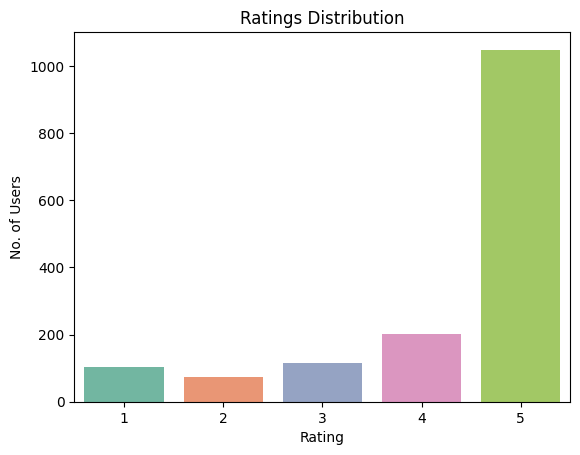

In [35]:
#Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Set a color palette
palette = sns.color_palette("Set2")  

# Create the count plot
sns.countplot(data=data, x='rating', palette=palette)

# Labeling the plot
plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

# Show the plot
plt.show()


### Data Processing

In [10]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date        0
review      0
rating      0
isEdited    0
userName    0
title       0
dtype: int64

In [11]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [12]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','isEdited','userName','review','title']
data = data.drop(remove_cols,axis='columns')

In [13]:
data.head()

,rating,complete_review
0,5,ChatGPT is a MUST HAVE APP .My TikTok follower...
1,4,"4.5 stars, here’s why .I recently downloaded t..."
2,2,"Performance issues. .In the beginning, this ap..."
3,3,Issues with accessibility for the blind .I tru...
4,4,This app is using an older version of your cus...


#### 1.Convert all the reviews to lowercase

In [14]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    chatgpt is a must have app .my tiktok follower...
1    4.5 stars, here’s why .i recently downloaded t...
2    performance issues. .in the beginning, this ap...
3    issues with accessibility for the blind .i tru...
4    this app is using an older version of your cus...
Name: complete_review, dtype: object

#### 2.Remove Punctuation

In [15]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

#### 3.Remove Emoji

In [16]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

#### 4.Remove Stopwords

In [17]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### 5.Apply Lemmatization

In [18]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

#### 6.Remove certain words

In [19]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

#### 7.Map ratings to positive, negative & neutral sentiment

 ###### 0 will represent negative sentiment

 ###### 1 will represent neutral sentiment

 ###### 2 will represent positive sentiment

In [20]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,5,must .my tiktok follower know much I ’m always...,2
1,4,"4.5 star , here ’ .i recently download overall...",2
2,2,"performance issue . .in begin , application re...",0
3,3,issue accessibility blind .i truly hope contin...,1
4,4,old version custom instruction .i really like ...,2


In [21]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

sentiment
2    81.17
0    11.43
1     7.40
Name: proportion, dtype: float64

#### Reviews Analysis

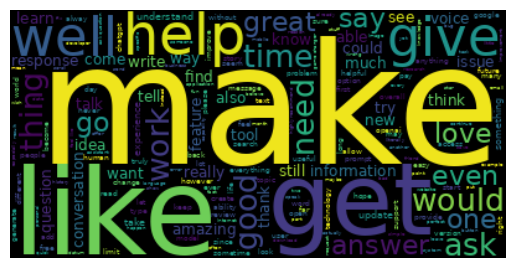

In [23]:
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Ensure you have the stopwords downloaded
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)

# Specify the font path (update this path based on your OS)
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Example for Linux

# Generate word cloud
wordcloud = WordCloud(stopwords=stopword, font_path=font_path).generate(text)

# Plotting
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


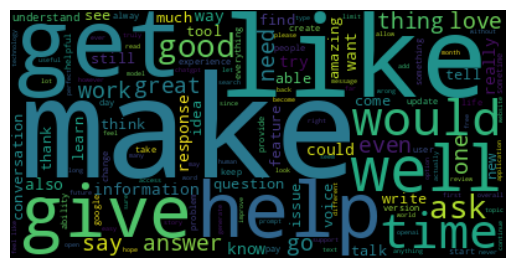

In [24]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

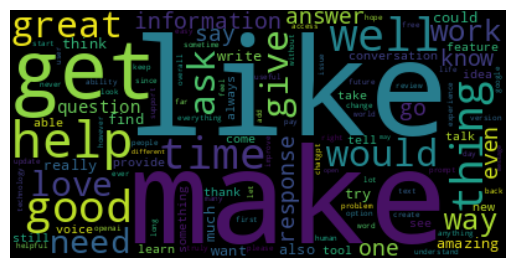

In [26]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

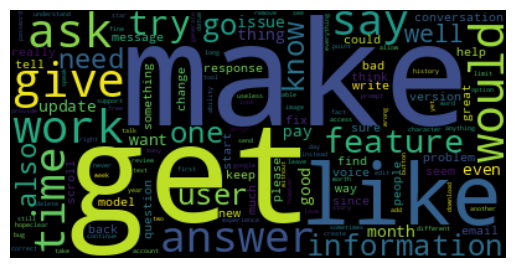

In [27]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

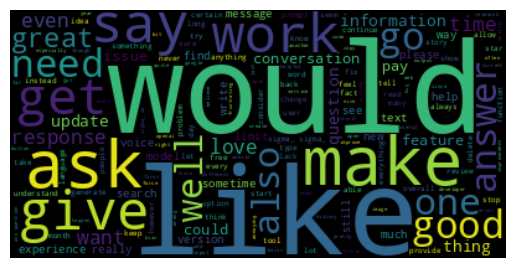

In [28]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Sentiment Analysis Model

##### Bag of Word Vectorization

In [29]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['complete_review'])
y = data['sentiment']

##### Handle Imbalanced Data

In [30]:
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

##### Train Test Split

In [31]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
                                                  y_oversampled,
                                                  test_size=0.15,
                                                  random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3187, 6031)
(563, 6031)
(3187,)
(563,)


 ##### Multinomial Naive Bayes

In [32]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       196
           1       0.85      0.88      0.87       181
           2       0.84      0.85      0.84       186

    accuracy                           0.85       563
   macro avg       0.85      0.86      0.85       563
weighted avg       0.85      0.85      0.85       563



##### Logistic Regression


In [33]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       196
           1       0.85      0.88      0.87       181
           2       0.84      0.85      0.84       186

    accuracy                           0.85       563
   macro avg       0.85      0.86      0.85       563
weighted avg       0.85      0.85      0.85       563



##### Random Forest

In [34]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       198
           1       0.93      0.97      0.95       179
           2       0.88      0.89      0.89       186

    accuracy                           0.91       563
   macro avg       0.91      0.92      0.92       563
weighted avg       0.92      0.91      0.91       563

